### SRM coverage analysis for p, ph mapping for 'phased' and unphased regions

This notebook is aimed at calculating the coverage of the genome using short read illumina data mapped with bwa againts primary contigs and primary contigs + haplotigs.

* calculate the coverage in 1000 bp sliding windows (200bp) for p and p+h mapping.
* calculate the coverage when mapping against primary contigs in regions with h overlap and without
* plot those out and see

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns
from pybedtools import BedTool
import matplotlib
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
import tempfile
from scipy.signal import argrelextrema

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [42]:
figure_title = 'Pst_104E Illumina mapped on Pst_104E'

In [33]:
#Define some PATH variables
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly'
COV_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/COV'
SRM_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/SRM'

In [6]:
genome = 'Pst_104E_v13'
mapping_project = "Pst79_folder5_on_%s" % genome
pbam_short_fn = 'Pst_104E_v13_p_ctg.bwamem.Pst79_folder5.bam'
phbam_short_fn = 'Pst_104E_v13_ph_ctg.bwamem.Pst79_folder5.bam'
h_on_p_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis/Pst_104E_v12_p_ctg.p_by_h_cov.gff'
threads = 6
OUT_PATH = os.path.join(COV_PATH, 'analysis', mapping_project)
if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH)
TMP_PATH = os.path.join(OUT_PATH, 'tmp')
if not os.path.exists(TMP_PATH):
    os.makedirs(TMP_PATH)

Now parallelize the bedtools and samtools functions.
This requires the following:
* split the window bedfile in as many non-overlapping bedfiels as we have threads and return the file locations as in a list.
* a function that takes a two filenames bedfile window and bam file and does a subprocess using samtools 





In [7]:
def run_command(command):
    print('\nRunnning now!\n')
    print(command)
    output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
    print('\nDone\nWith ouput:\n%s' % output)
    print(output)

In [8]:
def hello_print(command_list):
    print(command_list)

In [20]:
def faidx_genome(genome_fn, contig_fn):
    '''Generates a genome file used for samtools and such if not already present.
    Input: 
    Abspath filename of output genome_file.
    Abspath filename for genome contig file.'''
    if not os.path.exists(genome_fn):
        samtools_command = 'samtools faidx %s' % contig_fn
        run_command(samtools_command)
        genome_file_command = 'cat %s.fai | sort -k1,1n | cut -f 1,2 > %s' %(contig_fn, genome_fn)
        run_command(genome_file_command)
    else:
        print('%s already exists!' % genome_fn)

In [21]:
def sort_gff_file(gff_fn):
    '''Sorts gff file and returns the Abspath to the sorted gff file.'''
    gff3sport_pl = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/get_homologues/gff3sort/gff3sort.pl'
    if gff_fn.endswith('gff'):
        out_fn = gff_fn.replace('.gff', '.sorted.gff')
    elif gff_fn.endswith('gff3'):
        out_fn = gff_fn.replace('.gff3', '.sorted.gff3')
    else:
        print('Please make sure your gff %s file ends with gff or gff3' % gff_fn.split['/'][-1])
    sort_command = 'perl %s --precise %s > %s' %(gff3sport_pl, gff_fn, out_fn)
    run_command(sort_command)
    return out_fn

In [22]:
def bed_file_split(bed_fn, num_chunks, tmp_path = TMP_PATH):
    '''Splits a bedfile into even chunks of files plus the reads. Each file having the same number of lines.
    Input:
    bed file name abspath
    chunks to split into
    tmp_path where the split files get saved into.
    Returns:
    List of abspath filenames for split bed files.'''
    infilename = bed_fn
    number_of_lines = 0
    with open(infilename, 'rb') as infile:
        for x in infile:
            number_of_lines = number_of_lines + 1
    print('in_file_line_number:', number_of_lines)
    chunk_size = number_of_lines // num_chunks
    print('target chunk_size:', chunk_size)
    files = []
    
    previous = 0
    for i,y in enumerate([x for x in range(0, number_of_lines, chunk_size)]):
        if y == 0:
            continue
                    
        else:
            temp_fn = os.path.join(TMP_PATH, '%s_%s' % (os.path.basename(bed_fn), i-1))
            with open(temp_fn, 'w') as temp_file:
                with open(infilename, 'r') as infile:
                    for line_number, line in enumerate(infile):
                        if line_number < y and line_number >= previous:
                            print(line.rstrip(), file=temp_file)
                        else:
                            continue
            previous = y
            files.append(temp_fn)
    if y < number_of_lines:
        temp_fn = os.path.join(TMP_PATH, '%s_%s' % (os.path.basename(bed_fn), i))
        with open(temp_fn, 'w') as temp_file:
                with open(infilename, 'r') as infile:
                    for line_number, line in enumerate(infile):
                        if line_number >= y:
                            print(line.rstrip(), file=temp_file)
                        else:
                            continue
    files.append(temp_fn)
    return files

In [23]:
def samcov_file_split(basefile_name, chunks, tmp_path = TMP_PATH):
    """This function takes the samcov file and generates the split filenames necessary to run the 
    parallelized run_sam_bedcov."""
    chunk_base_name = os.path.join(tmp_path, os.path.basename(basefile_name))
    return_list = []
    for x in range(0, chunks):
        return_list.append('%s_%s' % (chunk_base_name, x))
    return return_list

In [24]:
def combine_samcov_files(file_list):
    """This function concatenates samcov files from a tmp folder into the folder below. And removes all tmp files."""
    command = 'cat'
    combined_file = os.path.basename(file_list[0])[:-2]
    combined_file_fn = os.path.join(os.path.dirname(file_list[0]),'..', combined_file)
    for file in file_list:
        command = command + ' %s' % file
    command = command + ' > %s'  % combined_file_fn
    run_command(command)

In [25]:
def remove_files(file_list):
    for file in file_list:
        os.remove(file)

In [26]:
def run_sam_bedcov(bed_fn, bam_fn, samcov_fn, parallel = False):
    """This function runst samtools bedcov. It also has the option to do this in parallel spliting up the bed_cov file in equal junks plus one.
    Input:
        bed file name as Abspath.
        bam file name as Abspath.
        Samcov file as Abspath.
        Option to run thinks in parllel. Set to False. Provide the number of threads you want to run -1.
    Output:
        It generate the samcov files and saves them to file."""
    command = 'samtools bedcov %s %s > %s' % (bed_fn, bam_fn, samcov_fn)
    if parallel != False and type(parallel) == int:
        split_bed_files = bed_file_split(bed_fn, parallel)
        split_samcov_files = samcov_file_split(samcov_fn, len(split_bed_files), tmp_path=TMP_PATH)
        bam_files = [bam_fn]*len(split_bed_files)
        n_threads = len(split_bed_files)
        Parallel(n_jobs=n_threads)(delayed(run_sam_bedcov)(bed, bam, sam) for bed, bam, sam in zip(split_bed_files, bam_files, split_samcov_files))
        combine_samcov_files(split_samcov_files)
        remove_files(split_samcov_files)
        remove_files(split_bed_files)
    else:
        run_command(command)

In [27]:
def diploid_coverage(df):
    """This function tries to define the 'diploid coverage' of a samcov dataframe in case of two major coverage peaks.
    In case of a single peak it will return its coverage.
    It checks if the dataframe contains high coverage outliers and removes those for the analysis.
    Input:
        Samcov dataframe. 
    Output:
        Location of diploid coverage peak for diploids.
        Location of haploid coverage peak in case of haploids.
    """
    #function that first checks if the dataframe if trimmed down
    if df.ave_cov.max() > 10 * df.ave_cov.mean():
        print("Reducing dataframe to quantile 0.99")
        q_up = 0.99
        q_down = 1 - 0.99
        low = x.quantile(q_down) - 1.5*(x.quantile(q_up) - x.quantile(q_down))
        high = x.quantile(q_up) + 1.5*(x.quantile(q_up) - x.quantile(q_down))
        df = df[(df.ave_cov >= low) & (df.ave_cov <= high)]
    cov_bin = pd.cut(df.ave_cov, bins=200)
    value_counts = cov_bin.value_counts().sort_index()
    value_counts_df = value_counts.reset_index()
    local_max = argrelextrema(value_counts.values, np.greater, order=10, mode ='wrap')[0]
    sub_df = value_counts_df.loc[local_max]
    sub_df['mids'] = sub_df['index'].apply(lambda x: float(x.mid))
    sub_df = sub_df[sub_df.ave_cov > sub_df.ave_cov.max()*0.1]
    #now comes the heuristic
    print('These are the options for the peaks that are greater than 10% of the max peak.')
    print(sub_df)
    if len(sub_df.mids) == 1:
        #print("step 1")
        return sub_df.mids[sub_df.mids.index[0]]
    elif len(sub_df.mids) == 2:
        #print('step 2')
        return sub_df.mids[sub_df.mids.index[1]]
    elif len(sub_df.mids) > 2:
        #drop everything at the left edge
        mids = sub_df.mids[np.array(sub_df['mids']) >0.1*df.ave_cov.mean()]
        if len(mids) == 1:
            #print('something')
            return mids[mids.index[0]]
            #continue
        elif len(mids) == 2:
            dvision = mids[mids.index[1]]/mids[mids.index[0]] 
            if 1.85 < dvision < 2.15:
                return mids[mids.index[1]]

In [43]:
def samcov_slurp(file_name, fil=True, low=0, high=1000000, quantile = False, norm = False, contig_fil = False):
    """Reads in a samcov file as a dataframe and can filter it by quantiles, high and low values.
    It can also normalize. Either by a given value or by the calculated diploid coverage if norm is set to true.
    If norm is set to false it will simply normalize by the overall mean coverage of the dataframe. This could be an issue
    for multi peak coverage plots.
    Input: 
        filename for samcov file.
    Options:
        fil: Filters the dataframe on low and high if quantile is False
        low: low filtering cut-off of coverage
        high: high filtering cut-off of coverage
            ONLY applicable if fil == True and quantile == False
        quantile: is the fraction used in the cut-off caclulcations.
        norm: False, True or integer. If False the norm coverage is simply calcuated dividing the ave cov by the mean of the ave_cov.
            If true normalization is done with the diploid coverage function. If int given norm is done with by dividing ave_cov with the integer.
        contig_fil: Can be either p or h to filter for pcontigs only or hcontigs only.
    """

    samcov_header = ['contig', 'start', 'stop', 'total_cov']
    df = pd.read_csv(file_name, sep='\t', header=None, names=samcov_header)
    df['ave_cov'] = df.total_cov/(df.stop-df.start)
    #rounder = pd.Series([0,0,0,0,2], index = df.columns)
    df.ave_cov = df.ave_cov.round()
    
    if fil == True and quantile == False:
        df = df[(df.ave_cov >= low) & (df.ave_cov <= high)]
    elif fil == True and type(quantile) == float:
        x = df.ave_cov
        q_up = quantile
        q_down = 1 - quantile
        low = x.quantile(q_down) - 1.5*(x.quantile(q_up) - x.quantile(q_down))
        high = x.quantile(q_up) + 1.5*(x.quantile(q_up) - x.quantile(q_down))
        df = df[(df.ave_cov >= low) & (df.ave_cov <= high)]
    if contig_fil == 'p':
        df = df[df.contig.str.startswith('pcontig')].copy()
    if contig_fil == 'h':
        df = df[df.contig.str.startswith('hcontig')].copy()
    if norm == False:
        df['norm_cov'] = df['ave_cov']/df['ave_cov'].mean()
    elif type(norm) == int:
        df['norm_cov'] = df['ave_cov']/float(norm)
    elif norm == True:
        calcuated_coverage = diploid_coverage(df)
        df['norm_cov'] = df['ave_cov']/float(calcuated_coverage)
        print("This is the calculated diploid coverage: %i" % calcuated_coverage)
    return df

### Program starts here ###

In [35]:
#define some filenames for assembly files
p_fn = os.path.join(BASE_AA_PATH, '%s_p_ctg.fa' % genome)
ph_fn = os.path.join(BASE_AA_PATH,'%s_ph_ctg.fa' % genome)
p_genome_file_fn = os.path.join(BASE_AA_PATH, '%s_p_ctg.genome_file' % genome)
ph_genome_file_fn = os.path.join(BASE_AA_PATH, \
                                 '%s_ph_ctg.genome_file' % genome)
#and mapping bam files
pbam_fn = os.path.join(SRM_PATH, pbam_short_fn)
phbam_fn = os.path.join(SRM_PATH, phbam_short_fn)

In [36]:
#run some indexing and genome_file commands
faidx_genome(p_genome_file_fn, p_fn)
faidx_genome(ph_genome_file_fn, ph_fn)
h_on_p_sorted_fn = sort_gff_file(h_on_p_fn)

/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_p_ctg.genome_file already exists!
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_ph_ctg.genome_file already exists!

Runnning now!

perl /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/get_homologues/gff3sort/gff3sort.pl --precise /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis/Pst_104E_v12_p_ctg.p_by_h_cov.gff > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis/Pst_104E_v12_p_ctg.p_by_h_cov.sorted.gff

Done
With ouput:
b''
b''


In [37]:
#now make some window files
p_window_1k200_bed = BedTool().window_maker(g=p_genome_file_fn, w=1000, s=200)
ph_window_1k200_bed = BedTool().window_maker(g=ph_genome_file_fn, w=1000, s=200)
h_on_p_bed = BedTool(fn=h_on_p_sorted_fn)
h_on_p_bed_pos_1k200_bed = p_window_1k200_bed.intersect(h_on_p_bed)
h_on_p_bed_neg_1k200_bed = p_window_1k200_bed.subtract(h_on_p_bed)

In [38]:
#define some outfile names
p_window_1k200_fn = os.path.join(OUT_PATH, '%s_p_ctg.p_window_1k200.cov' % mapping_project)
ph_window_1k200_fn = os.path.join(OUT_PATH, '%s_ph_ctg.ph_window_1k200.cov' % mapping_project)
p_h_on_p_window_1k200_fn = os.path.join(OUT_PATH, \
                                        '%s_ctg.h_on_p.p_window_1k200.cov' %mapping_project)
p_h_not_on_p_window_1k200_fn = os.path.join(OUT_PATH, \
                                        '%s_p_ctg.h_not_on_p.p_window_1k200.cov' %mapping_project)

In [39]:
#save out the bed files for overlaps
p_window_1k200_bed.saveas(p_window_1k200_fn.replace('.cov', '.bed'))
ph_window_1k200_bed.saveas(ph_window_1k200_fn.replace('.cov','.bed'))
h_on_p_bed_pos_1k200_bed.saveas(p_h_on_p_window_1k200_fn.replace('.cov', '.bed'))
h_on_p_bed_neg_1k200_bed.saveas(p_h_not_on_p_window_1k200_fn.replace('.cov', '.bed'))

<BedTool(/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/COV/analysis/Pst79_folder5_on_Pst_104E_v13/Pst79_folder5_on_Pst_104E_v13_p_ctg.h_not_on_p.p_window_1k200.bed)>

In [40]:
bed_list = [p_window_1k200_fn.replace('.cov', '.bed'), ph_window_1k200_fn.replace('.cov', '.bed'),\
            p_h_on_p_window_1k200_fn.replace('.cov', '.bed'), p_h_not_on_p_window_1k200_fn.replace('.cov', '.bed'),\
           p_h_on_p_window_1k200_fn.replace('.cov', '.bed'), p_h_not_on_p_window_1k200_fn.replace('.cov', '.bed')]
bam_list = [pbam_fn, phbam_fn, phbam_fn, phbam_fn,pbam_fn, pbam_fn]
samcov_list = [p_window_1k200_fn.replace('.cov', '.p_mapping.samcov'), ph_window_1k200_fn.replace('.cov', '.ph_mapping.samcov'),\
              p_h_on_p_window_1k200_fn.replace('.cov', '.ph_mapping.samcov'), p_h_not_on_p_window_1k200_fn.replace('.cov', '.ph_mapping.samcov'),\
              p_h_on_p_window_1k200_fn.replace('.cov', '.p_mapping.samcov'), p_h_not_on_p_window_1k200_fn.replace('.cov', '.p_mapping.samcov')]

In [ ]:
for bed, bam, sam in zip(bed_list, bam_list, samcov_list):
    run_sam_bedcov(bed, bam, sam, parallel=threads)

in_file_line_number: 416859
target chunk_size: 69476

Runnning now!

Runnning now!

Runnning now!




Runnning now!

Runnning now!

samtools bedcov /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/COV/analysis/Pst79_folder5_on_Pst_104E_v13/tmp/Pst79_folder5_on_Pst_104E_v13_p_ctg.p_window_1k200.bed_0 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/SRM/Pst_104E_v13_p_ctg.bwamem.Pst79_folder5.bam > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/COV/analysis/Pst79_folder5_on_Pst_104E_v13/tmp/Pst79_folder5_on_Pst_104E_v13_p_ctg.p_window_1k200.p_mapping.samcov_0

Runnning now!
samtools bedcov /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/COV/analysis/Pst79_folder5_on_Pst_104E_v13/tmp/Pst79_folder5_on_Pst_104E_v13_p_ctg.p_window_1k200.bed_3 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/SRM/Pst_104E_v13_p_ctg.bwamem.Pst79_folder5

In [44]:
p_only_pm_df = samcov_slurp(samcov_list[0], quantile = 0.98, norm = True)
p_only_pm_diploid_cov = int(diploid_coverage(p_only_pm_df))
max_ave_cov = p_only_pm_df.ave_cov.max()
max_norm_cov = p_only_pm_df.norm_cov.max()
p_only_phm_df = samcov_slurp(samcov_list[1], fil = True, low =0, high = max_ave_cov , norm = p_only_pm_diploid_cov, contig_fil='p')
h_only_phm_df = samcov_slurp(samcov_list[1], fil = True, low =0, high = max_ave_cov , norm = p_only_pm_diploid_cov, contig_fil='h')
p_with_h_only_phm_df = samcov_slurp(samcov_list[2], fil = True, low =0, high = max_ave_cov , norm = p_only_pm_diploid_cov, contig_fil='p')
p_without_h_only_phm_df = samcov_slurp(samcov_list[3], fil = True, low =0, high = max_ave_cov , norm = p_only_pm_diploid_cov, contig_fil='p')

These are the options for the peaks that are greater than 10% of the max peak.
               index  ave_cov      mids
34   (56.95, 58.625]     9108   57.7875
68  (113.9, 115.575]    17730  114.7375
This is the calculated diploid coverage: 114
These are the options for the peaks that are greater than 10% of the max peak.
               index  ave_cov      mids
34   (56.95, 58.625]     9108   57.7875
68  (113.9, 115.575]    17730  114.7375


In [45]:
#histogram of 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


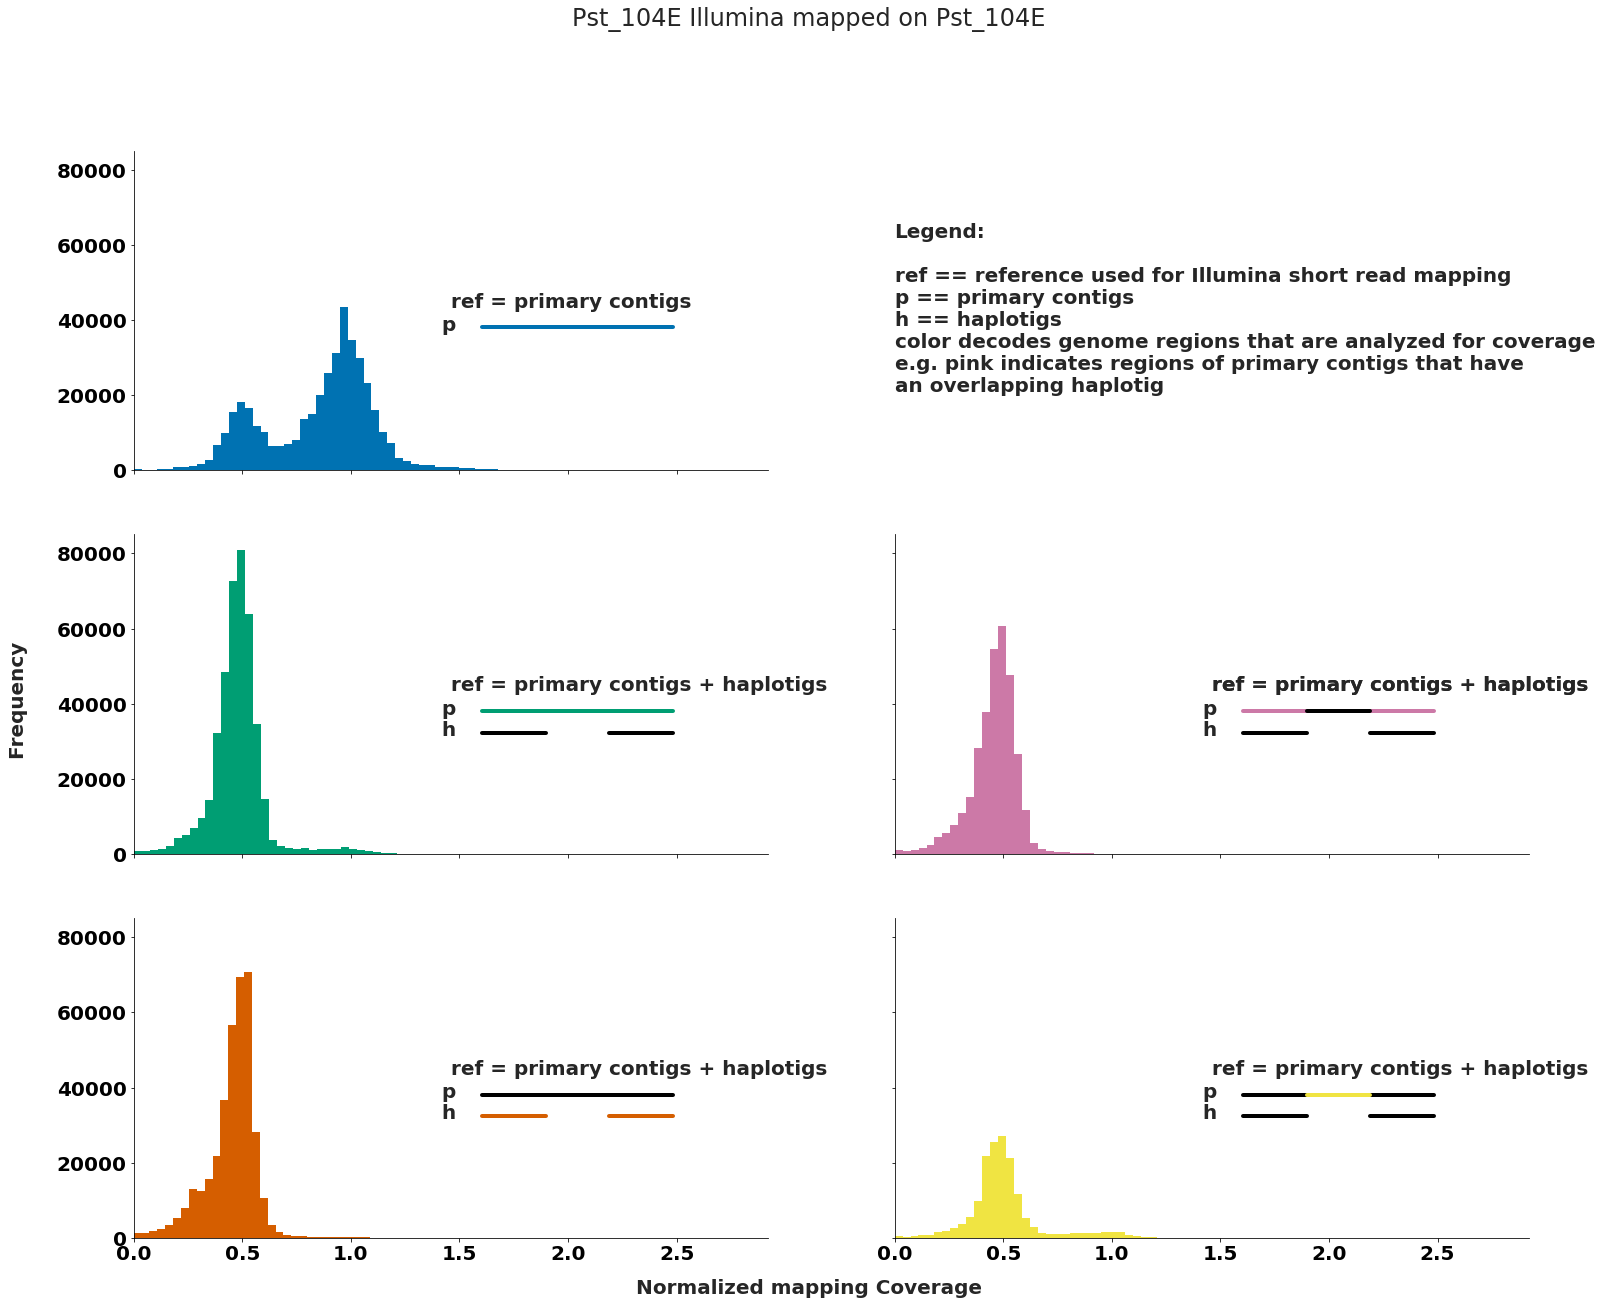

In [47]:
#now do the figure


bins =80

#
fig, ax1 = plt.subplots(3, 2, figsize=(25,20), sharex='all', sharey='all')
#set style
sns.set_style("ticks")
sns.despine()
pallete = sns.color_palette('colorblind')


ax1[0,0].hist(p_only_pm_df.norm_cov, bins=bins, color=pallete[0])

y_upper_lim = ax1[0,0].get_ylim()[1]
xstart_text = max_norm_cov/2
xincremend = max_norm_cov/20
y_upper_spot = y_upper_lim/1.2
yinremend = y_upper_lim/10

ax1[0,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs')
ax1[0,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[0])
ax1[0,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[0,0].set_xlim([0,max_norm_cov])

#now plot the ph mapping with primeray mapping only

ax1[1,0].hist(p_only_phm_df.norm_cov, bins=bins, color=pallete[1])
ax1[1,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[1])
ax1[1,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[1,0].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,0].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,0].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[1,0].set_xlim([0,max_norm_cov])


#now plot the ph mapping with haplotig mapping only


ax1[2,0].hist(h_only_phm_df.norm_cov, bins=bins, color=pallete[2])
ax1[2,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[2,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = 'k')
ax1[2,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[2,0].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = pallete[2])
ax1[2,0].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = pallete[2])
ax1[2,0].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[2,0].set_xlim([0,max_norm_cov])


#now plot the ph mapping with primaries with overlaps
ax1[1,1].hist(p_with_h_only_phm_df.norm_cov, bins=bins, color=pallete[3])
ax1[1,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,1].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[3])
ax1[1,1].plot([xstart_text+(3*xincremend), xstart_text+(5*xincremend)],[y_upper_spot, y_upper_spot] , lw =4, color = 'k')
ax1[1,1].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[1,1].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,1].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,1].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[1,1].set_xlim([0,max_norm_cov])

#now plot the ph mapping with primaries with overlaps
ax1[2,1].hist(p_without_h_only_phm_df.norm_cov, bins=bins, color=pallete[4])

ax1[2,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[2,1].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = 'k')
ax1[2,1].plot([xstart_text+(3*xincremend), xstart_text+(5*xincremend)],[y_upper_spot, y_upper_spot] , lw =4, color = pallete[4])
ax1[2,1].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[2,1].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[2,1].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[2,1].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')

ax1[2,1].set_xlim([0,max_norm_cov])

#add the labels
fig.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.09, 'Normalized mapping Coverage',ha='center', va='center')

#make plot [0,1] disappear
ax1[0,1].axis('off')
text = '''
Legend:\n
ref == reference used for Illumina short read mapping
p == primary contigs
h == haplotigs
color decodes genome regions that are analyzed for coverage
e.g. pink indicates regions of primary contigs that have
an overlapping haplotig
'''
ax1[0,1].text(0, y_upper_lim/3, text)
out_fn = os.path.join(OUT_PATH, '%s_SRM_coverage.png' % mapping_project)

plt.suptitle(figure_title)

#fig.savefig(out_fn, dpi=600)

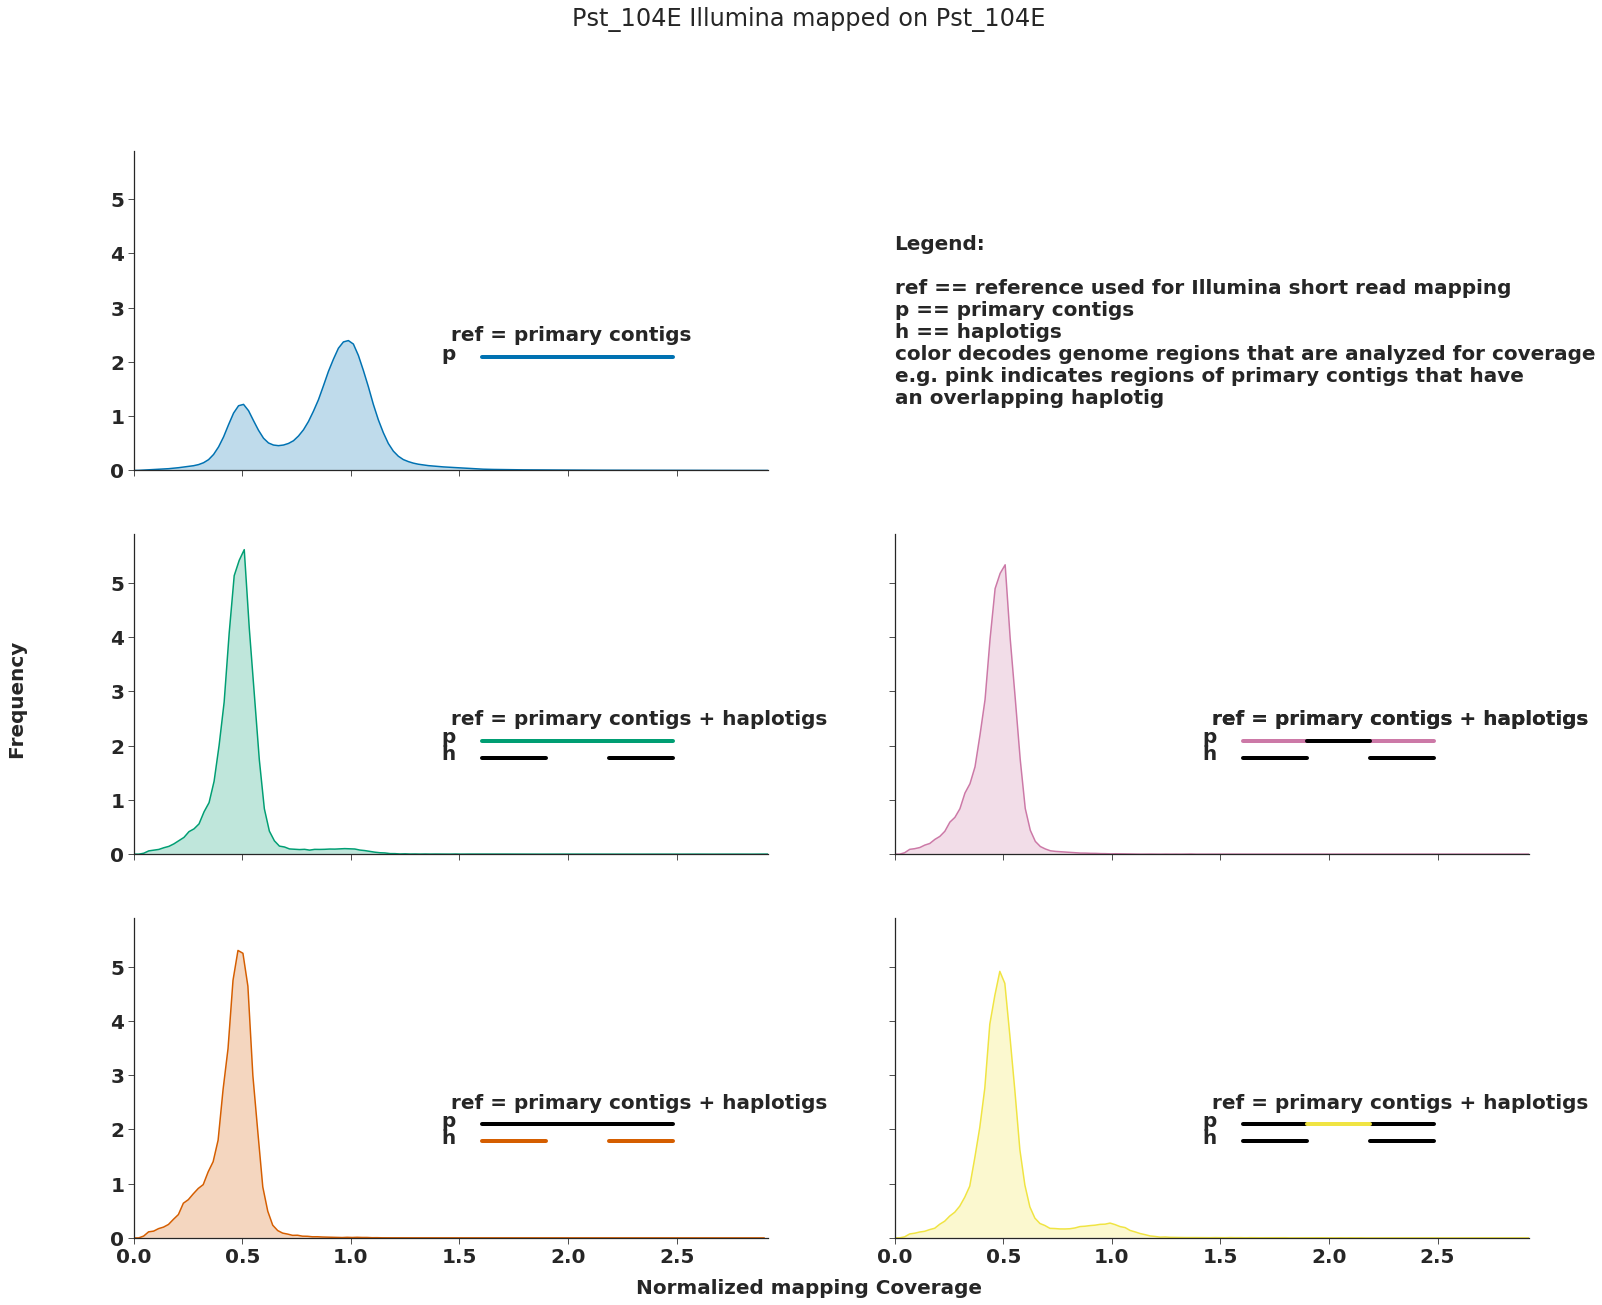

In [48]:
#now do the figure
fig, ax1 = plt.subplots(3, 2, figsize=(25,20), sharex='all', sharey='all')
#set style
sns.set_style("ticks")
sns.despine()
pallete = sns.color_palette('colorblind')
#sns.set(style="white", palette="muted", color_codes=True)

sns.kdeplot(p_only_pm_df.norm_cov, shade=True, color=pallete[0], ax=ax1[0,0], cut=0, legend=None)
#ax1[0,0].hist(p_only_pm_df.norm_cov, bins=100, color=pallete[0])

y_upper_lim = ax1[0,0].get_ylim()[1]
xstart_text = max_norm_cov/2
xincremend = max_norm_cov/20
y_upper_spot = y_upper_lim/1.2
yinremend = y_upper_lim/10

ax1[0,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs')
ax1[0,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[0])
ax1[0,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[0,0].set_xlim([0,max_norm_cov])

#now plot the ph mapping with primeray mapping only

sns.kdeplot(p_only_phm_df.norm_cov, shade=True, color=pallete[1], ax=ax1[1,0], cut=0, legend=None)
ax1[1,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[1])
ax1[1,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[1,0].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,0].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,0].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[1,0].set_xlim([0,max_norm_cov])


#now plot the ph mapping with haplotig mapping only

sns.kdeplot(h_only_phm_df.norm_cov, shade=True, color=pallete[2], ax=ax1[2,0], cut=0, legend=None)
ax1[2,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[2,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = 'k')
ax1[2,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[2,0].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = pallete[2])
ax1[2,0].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = pallete[2])
ax1[2,0].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[2,0].set_xlim([0,max_norm_cov])


#now plot the ph mapping with primaries with overlaps
sns.kdeplot(p_with_h_only_phm_df.norm_cov, shade=True, color=pallete[3], ax=ax1[1,1], cut=0, legend=None)
ax1[1,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,1].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[3])
ax1[1,1].plot([xstart_text+(3*xincremend), xstart_text+(5*xincremend)],[y_upper_spot, y_upper_spot] , lw =4, color = 'k')
ax1[1,1].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[1,1].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,1].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,1].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[1,1].set_xlim([0,max_norm_cov])

#now plot the ph mapping with primaries with overlaps

sns.kdeplot(p_without_h_only_phm_df.norm_cov, shade=True, color=pallete[4], ax=ax1[2,1], cut=0, legend=None)
ax1[2,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[2,1].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = 'k')
ax1[2,1].plot([xstart_text+(3*xincremend), xstart_text+(5*xincremend)],[y_upper_spot, y_upper_spot] , lw =4, color = pallete[4])
ax1[2,1].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[2,1].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[2,1].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[2,1].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')

ax1[2,1].set_xlim([0,max_norm_cov])

#add the labels
fig.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.09, 'Normalized mapping Coverage',ha='center', va='center')

#make plot [0,1] disappear
ax1[0,1].axis('off')
text = '''
Legend:\n
ref == reference used for Illumina short read mapping
p == primary contigs
h == haplotigs
color decodes genome regions that are analyzed for coverage
e.g. pink indicates regions of primary contigs that have
an overlapping haplotig
'''
ax1[0,1].text(0, y_upper_lim/3, text)
out_fn = os.path.join(OUT_PATH, '%s_SRM_coverage.png' % mapping_project)

plt.suptitle(figure_title)

#fig.savefig(out_fn, dpi=600)